In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import category_encoders as ce
from scipy.sparse import coo_matrix
import networkx as nx

from joblib import Parallel, delayed
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from classes_list import *
from customized_statistical_tests import *
from tmfg_core import *

In [2]:
random_state = 0
random.seed = random_state

### Dataset in mat format

In [24]:
dataset_name = 'RELATHE'
data = scipy.io.loadmat('./dataset/' + dataset_name)
X = pd.DataFrame(data['X'].astype(float))
y = pd.DataFrame(data['Y'][:, 0])

### Dataset in csv

In [14]:
dataset_name = 'census_income'
names_col = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 
             'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
             'hours_per_week', 'native_country', 'income']

df = pd.read_csv("./dataset/adult.data", names=names_col)

In [15]:
X = df.drop(['income'], axis = 1)
y = df['income']
#encode the target variable
y = y.apply(lambda x: 0 if x == ' <=50K' else 1)

X.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


### Implementation

In [5]:
def preproccessing_train_test_dict(X, y):

    numeric = X.select_dtypes(include=[np.number])
    cat_col = X.drop(numeric, axis=1)
    cat_col_name = list(cat_col.columns)
    y = y.values.reshape(len(y.values), )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

    #encode categorical variables with catboost encoder
    if len(cat_col_name) > 0:
        encoder = ce.CatBoostEncoder(cols=cat_col_name)
        X_train[cat_col_name] = encoder.fit_transform(X_train[cat_col_name], y_train)
        X_test[cat_col_name] = encoder.transform(X_test[cat_col_name])

    #standardize all numeric values
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    data_dictionary = {'X_train': X_train,
                        'X_test': X_test,
                        'y_train': y_train,
                        'y_test': y_test}
        
    return data_dictionary
    

def get_data_description(data_dictionary):
    description_dictionary = {'#_features': data_dictionary['X_train'].shape[1],
                                    '#_samples_training': data_dictionary['X_train'].shape[0],
                                    '#_samples_test': data_dictionary['X_test'].shape[0],
                                    'counting_labels_training': Counter(data_dictionary['y_train']),
                                    'counting_labels_test': Counter(data_dictionary['y_test'])}

    return description_dictionary


def get_ifs_feature(dataset_name, X_train, alpha, factor, num):
    ifs = IFS_class(num=num, dataset_name=dataset_name, alpha=alpha, factor=factor, step='cv')
    ifs.fit(X_train)
    return ifs.rank


def get_tmfg_feature(dataset_name, X_train, alpha, method, correlation_type, num):
    '''
    method = ['pearson', 'spearman', 'energy']
    correlation_types = ['normal', 'square']
    '''
    tmfg = TFS_class(num=num, dataset_name=dataset_name, alpha=alpha, method=method,
                           correlation_type=correlation_type, step='cv')
    tmfg.fit(X_train)
    return tmfg.rank


def ifs_classification_res(classification_name, clf, dataset_name, dataset, alpha, factor, num):

    X_train = dataset['X_train']
    X_test = dataset['X_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']

    features = get_ifs_feature(dataset_name, X_train=X_train, alpha=alpha, factor=factor, num=num)
    #retrieve the top n features from the training sample
    sample_X_train = X_train[:, features]
    sample_X_test = X_test[:, features]

    clf.fit(sample_X_train, y_train)

    cv_score = cross_val_score(clf, sample_X_train, y_train, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state), scoring='balanced_accuracy').mean()

    y_pred = clf.predict(sample_X_test)
    test_accuracy = balanced_accuracy_score(y_test, y_pred)

    res = {"Model": classification_name,
           "Dataset": dataset_name,
           "Selection_type": 'IFS',
           "Parameter": {"alpha": alpha, "factor": factor},
           "num_of_features": num,
           "cv_accuracy": cv_score,
           "test_accuracy": test_accuracy}
    
    return res 


def tmfg_classification_res(classification_name, clf, dataset_name, dataset, alpha, method, correlation_type, num):

    X_train = dataset['X_train']
    X_test = dataset['X_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']

    features = get_tmfg_feature(dataset_name, X_train=X_train, alpha=alpha, method=method, correlation_type=correlation_type, num=num)
    #retrieve the top n features from the training sample
    sample_X_train = X_train[:, features]
    sample_X_test = X_test[:, features]

    clf.fit(sample_X_train, y_train)

    cv_score = cross_val_score(clf, sample_X_train, y_train, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state), scoring='balanced_accuracy').mean()

    y_pred = clf.predict(sample_X_test)
    test_accuracy = balanced_accuracy_score(y_test, y_pred)

    res = {"Model": classification_name,
           "Dataset": dataset_name,
           "Selection_type": 'TMFG',
           "Parameter": {"alpha": alpha, "method": method, "correlation_type": correlation_type},
           "num_of_features": num,
           "cv_accuracy": cv_score,
           "test_accuracy": test_accuracy}
    
    return res 


def produce_corr_matrix(data_dictionary, method, alpha, correlation_type):

    data = pd.DataFrame(data_dictionary['X_train']).fillna(method='ffill').fillna(method='bfill')
    data = data.loc[:, data.std() > 0.0]

    if method == 'spearman':
        corr = data.corr(method='spearman')
        corr.to_csv(f'./correlation_res/spearman_{dataset_name}.csv', index=False)

    elif method == 'pearson':
        corr = data.corr(method='pearson')
        corr.to_csv(f'./correlation_res/pearson_{dataset_name}.csv', index=False)

    else:
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data)
        std = scaled_data.std(axis=0).reshape([-1,1])
        sigma_ij = np.maximum(std, std.transpose())

        corr_ij = 1 - np.abs(pd.DataFrame(data).corr(method='spearman').to_numpy())
        corr = alpha * sigma_ij + (1-alpha) * corr_ij

    weight_corr = corr

    if correlation_type == 'square' and method != 'energy':
        weight_corr = np.square(corr)

    return weight_corr


def graph_tmfg_centrality(data_dictionary, method, alpha, correlation_type, num_features):

    corr = produce_corr_matrix(data_dictionary, method, alpha, correlation_type)
    col_name = list(X.columns)

    tmfg = TMFG(pd.DataFrame(corr))
    cliques, seps, JS = tmfg.compute_TMFG()

    centrality = nx.degree_centrality(nx.DiGraph(np.array(JS)))
    #sparse matrix
    A = coo_matrix(JS)

    G = nx.Graph()

    for i, j in zip(A.row, A.col):
        G.add_edge(i, j)

    top_n_nodes = sorted(centrality, key=centrality.get, reverse=True)[:num_features]
    color_map = []

    for node in G:
        if node in top_n_nodes:
            color_map.append('red')
        else:
            color_map.append('lightblue')

    #retrieve top column name
    top_name = [col_name[i] for i in top_n_nodes]

    sorted_dict = dict(sorted(dict(zip(top_n_nodes, top_name)).items()))
    print(sorted_dict)

    pos = nx.spring_layout(G)
    edges = G.edges()
    weights = [corr[u][v] for u,v in edges]
    nx.draw(G, pos, width=weights, node_color=color_map, with_labels=True)
    plt.show()


def plot_centrality(data_dictionary, method, alpha, correlation_type):

    corr = produce_corr_matrix(data_dictionary, method, alpha, correlation_type)
    col_name = list(X.columns)

    tmfg = TMFG(pd.DataFrame(corr))
    cliques, seps, JS = tmfg.compute_TMFG()

    centrality = nx.degree_centrality(nx.DiGraph(np.array(JS)))

    sorted_centrality = [pair[1] for pair in sorted(centrality.items(), key=lambda item: item[1], reverse=True)]

    plt.plot(range(len(sorted_centrality)), sorted_centrality)
    plt.title('Centrality Plot')
    plt.xlabel('n')
    plt.ylabel('Centrality')
    plt.show()
    

### Evaluation

In [25]:
dataset = preproccessing_train_test_dict(X, y)

#### Parameters

In [26]:
alpha = 0.5
factor = 0.9
correlation_method = 'pearson'
correlation_type = 'normal'

In [27]:
linearsvc = LinearSVC(random_state=random_state, max_iter=50000)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=random_state)
xgb = XGBClassifier()

clf_name = ['LinearSVC', 'KNN', 'DecisionTree']
clf_ls = [linearsvc, knn, dt]

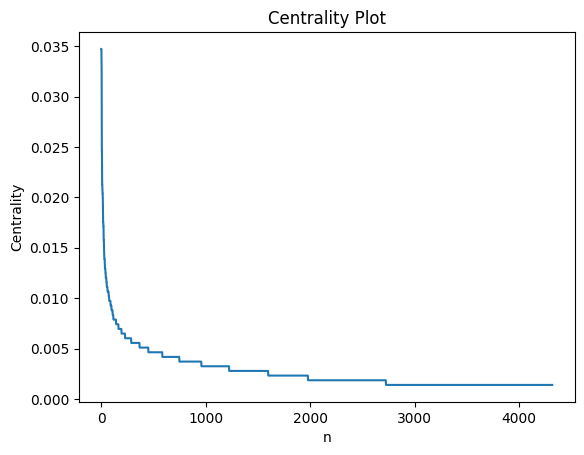

In [28]:
plot_centrality(dataset, correlation_method, alpha, correlation_type)

#### Result

In [29]:
res = []

for i in [50, 100, 200, 300, 400, 500, X.shape[1]]:
    for j in range(len(clf_ls)):
        res.append(tmfg_classification_res(clf_name[j], clf_ls[j], dataset_name, dataset, alpha, correlation_method, correlation_type, i))

In [ ]:
res_df = pd.DataFrame(res).sort_values(by = ['Model', 'num_of_features'])
res_df

,Model,Dataset,Selection_type,Parameter,num_of_features,cv_accuracy,test_accuracy
2,DecisionTree,census_income,TMFG,"{'alpha': 0.5, 'method': 'pearson', 'correlati...",2,0.651924,0.542920
5,DecisionTree,census_income,TMFG,"{'alpha': 0.5, 'method': 'pearson', 'correlati...",4,0.676042,0.682808
8,DecisionTree,census_income,TMFG,"{'alpha': 0.5, 'method': 'pearson', 'correlati...",6,0.684859,0.647198
11,DecisionTree,census_income,TMFG,"{'alpha': 0.5, 'method': 'pearson', 'correlati...",8,0.700886,0.666927
14,DecisionTree,census_income,TMFG,"{'alpha': 0.5, 'method': 'pearson', 'correlati...",10,0.697221,0.701465
17,DecisionTree,census_income,TMFG,"{'alpha': 0.5, 'method': 'pearson', 'correlati...",14,0.744026,0.739689
1,KNN,census_income,TMFG,"{'alpha': 0.5, 'method': 'pearson', 'correlati...",2,0.688070,0.588643
4,KNN,census_income,TMFG,"{'alpha': 0.5, 'method': 'pearson', 'correlati...",4,0.709158,0.713165
7,KNN,census_income,TMFG,"{'alpha': 0.5, 'method': 'pearson', 'correlati...",6,0.715726,0.715949
10,KNN,census_income,TMFG,"{'alpha': 0.5, 'method': 'pearson', 'correlati...",8,0.736710,0.735092


In [ ]:
res_df.pivot_table(values=['test_accuracy'], index='Model', columns='num_of_features')


test_accuracy                                          \
num_of_features            2         4         6         8         10   
Model                                                                   
DecisionTree         0.542920  0.682808  0.647198  0.666927  0.701465   
KNN                  0.588643  0.713165  0.715949  0.735092  0.734517   
LinearSVC            0.672606  0.705820  0.706095  0.718652  0.718419   

                           
num_of_features        14  
Model                      
DecisionTree     0.739689  
KNN              0.746345  
LinearSVC        0.747679

{3: 'education', 4: 'education_num', 5: 'marital_status', 6: 'occupation', 7: 'relationship'}


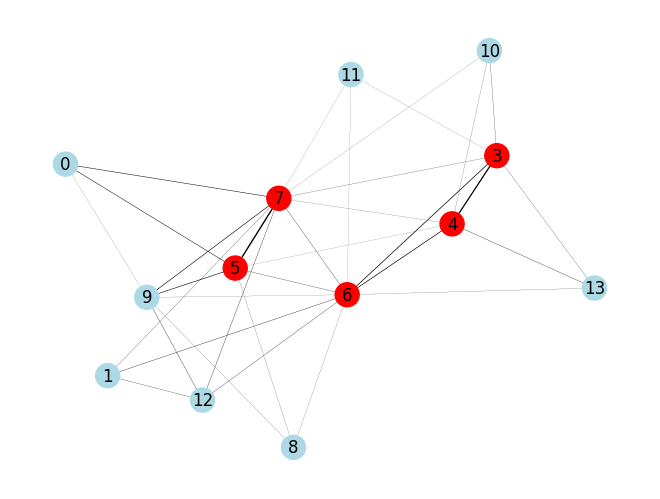

In [23]:
graph_tmfg_centrality(dataset, correlation_method, alpha, correlation_type, 5)